In [7]:
import numpy as np
import scipy as sp
from fitness_funs_non_dim import *
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp


In [5]:
%%writefile group_w_pop_funs.py
import numpy as np
import scipy as sp
from fitness_funs_non_dim import *


def group_formation_model_non_dim(T, F_of_x_vec,P,N1,N2, params):
    '''
    the full system of balance equations for x = 1,2,3,...,x_max, non-dimensionalized
    @inputs:
    T - scaled time, necessary for running with solve_ivp
    F_of_x_vec - a vector of the (scaled) number of groups of 
            size 1, 2, 3, ..., x_max (maximum group size)
    P, N1, N2 - scaled population size of predators, big prey, small prey, respectivel
    if_groups_change = Bool, True --> preds can join/leave groups. 
                            False --> only birth/death affect group sizes
    params - is a dictionary of the parameters that must contain: 
            β1, β2, A1, H1, H2, η1, η2, α1_of_1, α2_of_1, s1, s2, limited_portions, 
            Tx, d, ξ, r, γ, pop_process
    @ returns
    dF_dT for x = 1, 2, ..., xmax
    '''
    x_max = params['x_max']; Tx = params['Tx']; 
    η1 = params['η1']; η2 = params['η2']; tildeδ = 1 - η1 - η2
    d = params['d']; ξ = params['ξ']
    F_of_x_vec = np.append(F_of_x_vec,0) # so can find dfdt at x = x_max
    
    def F(x):
        return F_of_x_vec[x-1]
    def S(x,y):
        return best_response_fun_given_fitness(x,y,fitnessvec,d)
    def ψ(x):
        F_of_1 = F_of_x_vec[0]
        if x== 1 and F_of_1 >=1:
            return ξ *F_of_1 * S(2,1)#( ξ *F_of_1 - 1) * S(2,1)
        elif x == 1 and F_of_1 < 1:
            return ξ * F_of_1 * S(2,1)
        elif x <= x_max - 1:
            return ξ * F_of_1*S(x+1,1)
        else:
            return 0
    def fun_deaths(x):
        return tildeδ * Tx * ( - x*F(x) + (x+1) * F(x+1) )
    def ϕ(x):
        return x*S(1,x) if x <= x_max else 0
    
    xvec = np.arange(1,x_max+1,1)
    # it \tau_x > 0make population matrix = birth matrix + death matrix
    fitnessvec = fitness_from_prey_non_dim(xvec, N1, N2, **params)
    dFdT_vec = np.zeros(x_max)
    include_pop_process = 1 if params['pop_process'] == True else 0
    for x in xvec:
        if x == 1:
            Q_1 = 2*F(2)*ϕ(2) + np.sum([F(y) * ϕ(y) for y in range(3,x_max+1)]) \
                    - sum([F(y-1)*ψ(y-1) for y in range(2,x_max+1)])
            tilde_w_vec = per_capita_fitness_from_prey_non_dim(xvec, N1, N2, **params)
            births = Tx * np.sum(F_of_x_vec[:-1] * xvec * tilde_w_vec)
            dFdT = (Q_1 \
                    + include_pop_process*(births + fun_deaths(1)))/Tx
        elif x == 2:
            Q_2 = -F(2)*ϕ(2) - F(2)*ψ(2) + 0.5*F(1)*ψ(1) + F(3)*ϕ(3)
            dFdT = (Q_2 \
                    + include_pop_process*fun_deaths(2))/Tx
        else:
            Q_x = -F(x)*ϕ(x) - F(x) * ψ(x) + F(x-1)*ψ(x-1) + F(x+1)*ϕ(x+1)
            dFdT = (Q_x \
                    + include_pop_process*fun_deaths(x))/Tx
        
        dFdT_vec[x-1] = dFdT
    return dFdT_vec
    

def fun_leave_group(x, fitnessvec, x_max, d):
    '''
    The probability an individual leaves a group of size x. ϕ(x) in the text
    @inputs
    x - current grp size (before leaving)
    fitnessvec = vector of fitnesses for each group size
    x_max - parameter, maximum group size
    d = parameter determining steepness of best response function

    @ example:
    >> fitnessvec = array([0.24166667, 0.45833333, 0.53055556])
    >> fun_leave_group(xvec=[1,2,3], fitnessvec, x_max=3, d=100)
    array([0.5       , 0.03915869, 0.01923075])
    '''
    # deciding between being alone and staying in group of size x
    return best_response_fun_given_fitness(1,x,fitnessvec,d)

def best_response_fun_given_fitness(x,y,fitnessvec, d):
    '''
    Compares W(x) to W(y) to "decide" on group size y or x
    @inputs
    x - potentially new group size
    y - current grp size
    fitnessvec - vector of fitnesses fro x = 1, 2, ..., xmax
    d - steepness, or sensitivity, of best response function
    params - dictionary of params used by the rest of the model 
    @returns:
    float between 0 and 1
    '''
    W_of_x = fitnessvec[x-1]
    W_of_y = fitnessvec[y-1]
    W_min = min(W_of_x, W_of_y)
    W_max = max(W_of_x, W_of_y)
    numerator = (W_of_x/W_max)**d
    denominator = 1 + (W_min/W_max)**d # this adjustment helps avoid dividing by zero from numpy rounding
    return numerator/denominator
    
    # if W_of_x**d + W_of_y**d < 1e-100: # note that then at this point it will be 
    #                                     #rounded to 0, 
    #                                     # but since W_of_y**d must be less than 1e-300, 
    #                                     # can approximate as 1 - (W(y)/W(x))**d
    #     # option 1: both W_of_x and W_of_y are really really small
    #     # option 2: both are really small, but one is much bigger than the other
    #     # scale the smaller 1:
    #     W_min = min(W_of_x, W_of_y)
    #     W_max = max(W_of_x, W_of_y)
    #     numerator = (W_of_x/W_max)**d
    #     denominator = 1 + (W_min/W_max)**d
    #     return numerator/denominator
    # else:
    #     return W_of_x**d/(W_of_x**d + W_of_y**d)
    
def best_response_fun(x,y, N1,N2, d, **params):
    '''
    Compares W(x) to W(y) to "decide" on group size y or x
    @inputs
    x - potentially new group size
    y - current grp size
    N1, N2 - big prey and small prey scaled pop size
    d - steepness, or sensitivity, of best response function
    params - dictionary of params used by the rest of the model
    @returns:
    float between 0 and 1
    
    '''
    W_of_x = fitness_from_prey_non_dim(x, N1, N2, **params)
    W_of_y = fitness_from_prey_non_dim(y, N1, N2, **params)
    return W_of_x**d/(W_of_x**d + W_of_y**d)

    
def check_at_equilibrium(final_distribution, P, N1, N2,pop_process,**params):
    '''
    check dF(x)/dT \approx 0
    @ returns: array dFdT_, and 1 if at equilibrium or 0 if not
    '''
    T = 1 # this doesn't matter
    dFdT_ = group_formation_model_non_dim(T, final_distribution,P,N1,N2, params)
    at_equilibrium = np.abs(dFdT_) > 1e-10
    if sum(at_equilibrium) > 0: # at least one df(x)/dt is not zero
        return dFdT_, 0
    else:
        return dFdT_, 1

def model_one_x(T, initialstate, x, params):
    initialstate = np.array(initialstate)
    initialstate[np.abs(initialstate)<1e-11] = 0
    P, N1, N2 = initialstate
    F_of_x_vec = np.zeros(params['x_max'])
    F_of_x = P/x
    F_of_x_vec[x-1] = F_of_x
    dPdT = fun_dPdT_non_dim(P, N1, N2, F_of_x_vec, **params)
    dN1dT = fun_dN1dT_non_dim(P, N1, N2, F_of_x_vec, **params)
    dN2dT = fun_dN2dT_non_dim(P, N1, N2, F_of_x_vec, **params)
    return [dPdT, dN1dT, dN2dT]


def model_one_x_evolve(T, initialstate, params):
    '''
    Model where all predators approximated as in groups of same size
    tracks the evolution of the number of helpers.....group members - 1 
            (so the number of subordinates, perhaps)
    initialstate = P, N1, N2, y (scaled pop size of preds, big prey, and small prey, and 
                    num. of helpers)

    @returns:
    [dPdT, dN1dT, dN2dT, dydT]
    '''
    initialstate = np.array(initialstate)
    initialstate[np.abs(initialstate)<1e-11] = 0
    P, N1, N2, y= initialstate
    # y is the number of subordinates. x, group size, is 1 + y
    F_of_x_vec = np.zeros(params['x_max'])
    F_of_x = P/(1+y)
    F_of_x_vec[y] = F_of_x
    dPdT = fun_dPdT_non_dim(P, N1, N2, F_of_x_vec, **params)
    dN1dT = fun_dN1dT_non_dim(P, N1, N2, F_of_x_vec, **params)
    dN2dT = fun_dN2dT_non_dim(P, N1, N2, F_of_x_vec, **params)
    dydT = fun_dydT_non_dim(N1, N2, y, **params)
    return [dPdT, dN1dT, dN2dT, dydT]

def full_model(T, initialstate, arg, params):
    
    # i put arg there as a place holder because somehow makes ivp_solver work
    
    initialstate = np.array(initialstate)

    # this helps for numpy issues
    initialstate[np.abs(initialstate)<1e-11] = 0
    
    P,N1,N2 = initialstate[0:3]
    F_of_x_vec = initialstate[3:]
    dPdT = fun_dPdT_non_dim(P, N1, N2, F_of_x_vec, **params)
    dN1dT = fun_dN1dT_non_dim(P, N1, N2, F_of_x_vec, **params)
    dN2dT = fun_dN2dT_non_dim(P, N1, N2, F_of_x_vec, **params)
    dFdT_vec = group_formation_model_non_dim(T, F_of_x_vec,P,N1,N2, params)
    # if if_groups_change:
    #     dFdT_vec = group_formation_model_non_dim(T, F_of_x_vec,P,N1,N2, 
    #                                              if_groups_change, params)
    # else:
    #     x = np.argwhere(F_of_x_vec>0)[0][0] + 1
    #     dFdT_vec = np.zeros(params['x_max'])
    #     dFdT_vec[x-1] = dPdT/x
    

    return [dPdT, dN1dT, dN2dT, *dFdT_vec]
def fun_dydT_non_dim(N1, N2, y, Tx, **params):
    W_of_x = fitness_from_prey_non_dim(1+y, N1, N2, **params)
    W_of_1 = fitness_from_prey_non_dim(1, N1, N2, **params)

    return (W_of_x - W_of_1)/Tx
    
    
def fun_dPdT_non_dim(P, N1, N2, F_of_x_vec, η1, η2, β1, β2, **params):
    '''
    the equation for dPdT, the change in predator population size versus time, 
    non-dimensionalized. 

    @inputs
    P, N1, N2 - nondimensionalized predator, big prey, and small prey pop sizes
    F_of_x_vec - array of F(1), F(2), ... , F(x_max)
    params - dic of params that must at least include H1, H2, α1_of_1, α2_of_1, s1, s2,
    η1, η2 - scaled growth rates of big prey, small prey
    β1, β2 - scaled profitability of hunting big prey, small prey
    '''
    x_vec = np.arange(1,params['x_max']+1,1)
    tildeY1_of_x = fun_response_non_dim(x_vec,N1,N2,1,**params)
    tildeY2_of_x = fun_response_non_dim(x_vec,N1,N2,2,**params)
    tildeδ = 1 - η1 - η2
    total_fitness_per_x = β1 * tildeY1_of_x + β2 * tildeY2_of_x
    return np.sum(F_of_x_vec * total_fitness_per_x) - tildeδ*P

def fun_dN1dT_non_dim(P, N1, N2, F_of_x_vec, η1, A1, **params):
    '''
    dN1dT, the change in big prey pop size versus time, non-dim'ed
    @inputs:
    P, N1, N2 - non-dim'ed pred, big prey, and small prey pop sizes
    F_of_x_vec - array of F(1), F(2), ... , F(x_max)
    params - dic of params: must at least include H1, H2, α1_of_1, α2_of_1, s1, s2,
    η1 - scaled growth rate of big prey
    A1 - scaled attack rate of big prey
    '''
    x_vec = np.arange(1,params['x_max']+1,1)

    tildeY1_of_x = fun_response_non_dim(x_vec,N1,N2,1,**params)
    return η1*N1*(1-N1) - A1 * np.sum(F_of_x_vec * tildeY1_of_x)

def fun_dN2dT_non_dim(P, N1, N2, F_of_x_vec, η2, A1, **params):
    '''
    dN2dT, the change in small prey pop size versus time, non-dim'ed
    @inputs:
    P, N1, N2 - non-dim'ed pred, big prey, and small prey pop sizes
    F_of_x_vec - array of F(1), F(2), ... , F(x_max)
    params - dic of params: must at least include H1, H2, α1_of_1, α2_of_1, s1, s2,
    η2 - scaled growth rate of small prey
    A1 - scaled attack rate of big prey
    '''
    A2 = 1 - A1
    x_vec = np.arange(1,params['x_max']+1,1)

    tildeY2_of_x = fun_response_non_dim(x_vec,N1,N2,2,**params)
    
    return η2*N2*(1-N2) - A2 * np.sum(F_of_x_vec * tildeY2_of_x)



def mean_group_size_membership(F_of_x_vec, x_max, P):
    '''
    average group size any individual is in
    
    # columns of F_of_x_vec should be = x_max
    this is not the same as the average group size
    '''
    x_vec = np.arange(1,x_max+1,1)
    frequency_in_group_size_x = (F_of_x_vec*x_vec).T/P
    vec_to_sum = x_vec*frequency_in_group_size_x.T
    return vec_to_sum.sum(1)

Overwriting group_w_pop_funs.py


In [17]:
H=2
params_pop = dict(η1 = 0.2, η2 = 0.4, A1 = 0.5, β1 = 10, β2 = 1, H1=H, H2=H, 
                  α1_of_1=0.05, α2_of_1=0.95, 
                  s1=2, s2=2, α2_fun_type = 'constant',
                  x_max = 10, ξ = 2, d = 20,
                 Tx = 10, r = 0, γ = 0, pop_process = True)
initialstate = 

In [186]:
P_reg = 5; N1_reg = 1; N2_reg = 1

In [212]:
H=2
params_pop = dict(η1 = 0.2, η2 = 0.4, A1 = 0.5, β1 = 10, β2 = 1, H1=H, H2=H, 
                  α1_of_1=0.05, α2_of_1=0.95, 
                  s1=2, s2=2, α2_fun_type = 'constant',
                  x_max = 10, ξ = 2, d = 20,
                 Tx = 10, r = 0, γ = 0, pop_process = True)
P_reg = 5; N1_reg = 1; N2_reg = 1
params = params_pop
x_max = params['x_max']
initialstate = np.array([P_reg, *np.zeros(x_max - 1)])
F_of_x_vec = initialstate
#group_formation_model_non_dim(T, F_of_x_vec,P_reg,N1_reg,N2_reg, params_pop.copy())


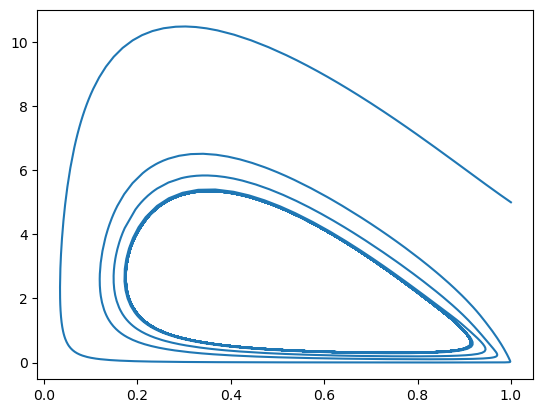

In [213]:
initialstate = [P_reg, N1_reg, N2_reg, *F_of_x_vec]
t_f=5000  
out2 = solve_ivp(full_model, [0, t_f], initialstate, method="LSODA",
                args=(True,params))
plt.plot(out2.y[1],out2.y[0])

In [214]:
P,N1,N2 = out2.y[0:3]
F_of_x_vec = out2.y[3:]

In [215]:
xvec = np.arange(1,11)

In [216]:
mean_x = mean_group_size_membership(F_of_x_vec.T, 10, P)

Text(0, 0.5, 'Mean Sampled Group Size')

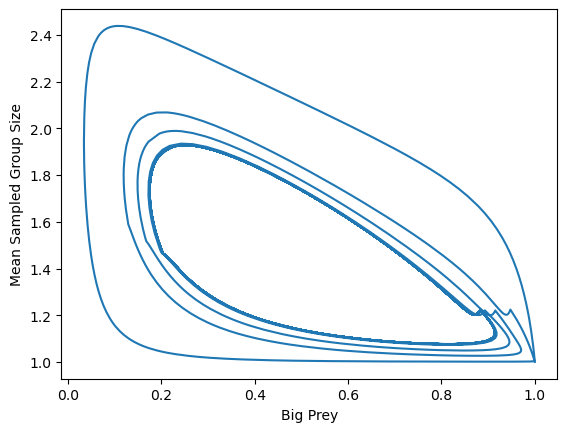

In [217]:
plt.plot(N1, mean_x)
plt.xlabel('Big Prey')
plt.ylabel('Mean Sampled Group Size')

Text(0, 0.5, 'Mean Sampled Group Size')

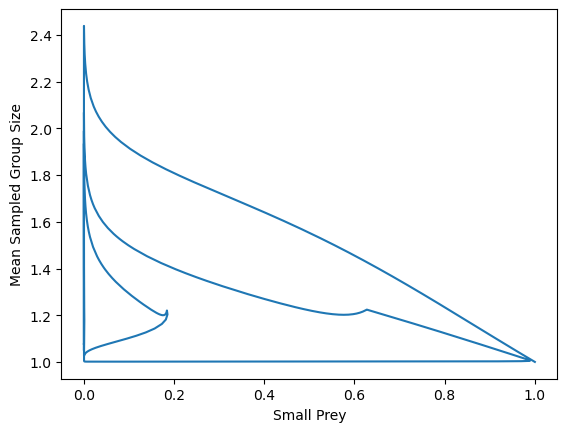

In [219]:
plt.plot(N2, mean_x)
plt.xlabel('Small Prey')
plt.ylabel('Mean Sampled Group Size')

In [220]:
N2[-1]

-8.014419779563326e-13

(0.0, 2000.0)

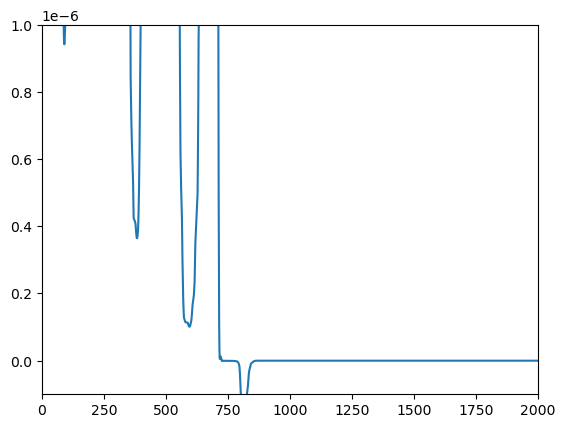

In [221]:
plt.plot(N2)
plt.ylim([-0.0000001,0.000001])
plt.xlim(0,2000)


In [104]:
3*6.35055076e-04

0.0019051652279999999

In [114]:
F_of_x_vec[:,0]

array([5., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [112]:
scaled_F = np.arange(1,11,1)**2*F_of_x_vec.T

In [113]:
scaled_F.T.sum(0)

array([5.        , 5.00006755, 5.0001351 , ..., 0.3918491 , 0.41710479,
       0.42798468])

In [90]:
np.arange(1,11,1)*F_of_x_vec.T

array([5., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [85]:
mean_group_size_membership(F_of_x_vec, 10)

ValueError: operands could not be broadcast together with shapes (10,) (10,40) 

(0.0, 20.0)

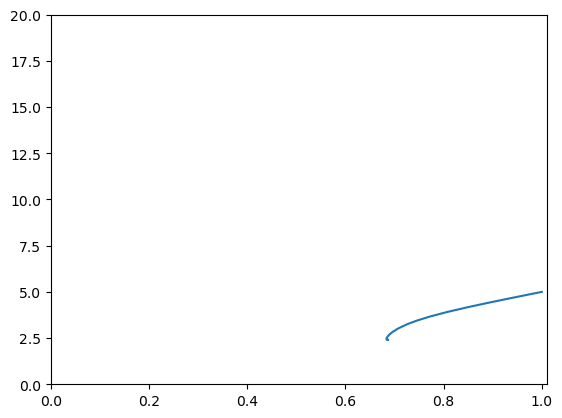

In [78]:
x=10
F_of_x_vec = np.zeros(params['x_max'])
F_of_x_vec[x-1] = P_reg/x
initialstate = [P_reg, N1_reg, N2_reg, *F_of_x_vec]
t_f=80000
out2 = solve_ivp(full_model, [0, t_f], initialstate, method="LSODA",
                args=(False,params))
plt.plot(out2.y[1],out2.y[0])
plt.xlim([0,1.01])
plt.ylim([0,20])

In [43]:
F_of_x_vec = out2.y[3:,:]

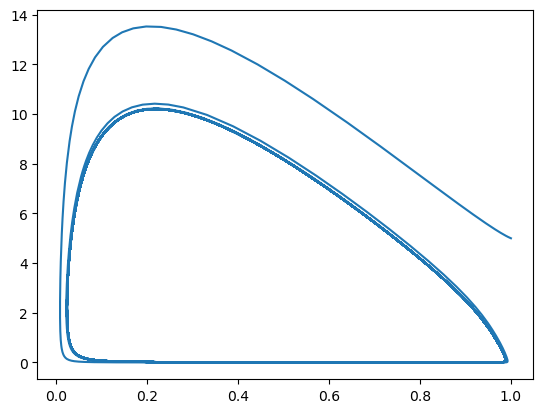

In [274]:
initialstate = [P_reg, N1_reg, N2_reg, *F_of_x_vec]
t_f=500001
out2 = solve_ivp(full_model, [0, t_f], initialstate, method="LSODA",
                args=(1,params))

In [268]:
initialstate = out2.y[:,-1]
P,N1,N2 = initialstate[0:3]

In [270]:
N2 = 0

In [272]:
out = full_model(T, initialstate, 1,params.copy())

In [273]:
out

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [278]:
fun_dPdT_non_dim(P, N1, N2, F_of_x_vec, **params)

0.0

In [219]:
initialstate = [P_reg, N1_reg, N2_reg, *F_of_x_vec]
t_f=100
out2 = solve_ivp(full_model, [0, t_f], initialstate, method="LSODA",
                args=(1,params))

In [220]:
out2.y[:,-1]

array([9.38729603e+00, 3.75116171e-01, 1.67057602e-10, 5.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00])

In [158]:
N1 = out.y[1]
ind_gets_weird = np.argwhere(N1<0)[0][0]
ind_start = ind_gets_weird - 1

In [161]:
out.y[:,ind_start+1]

array([ 1.47383863e+01, -1.07892661e-07, -2.16909217e-10,  3.21615563e-01,
        2.28127026e+00,  1.90806365e+00,  1.07477508e+00,  4.82656571e-01,
        1.82580949e-01,  5.96217724e-02,  1.68490878e-02,  3.94886889e-03,
        6.58391567e-04])

In [162]:
weird_start = out.y[:,ind_start]
print(weird_start)

[1.53090854e+01 6.21259991e-08 2.15434651e-11 3.15410856e-01
 2.28627994e+00 1.95223519e+00 1.12681145e+00 5.19486082e-01
 2.01966674e-01 6.78825129e-02 1.98151241e-02 4.82314322e-03
 8.34963983e-04]


In [163]:
x_vec = np.arange(1,11,1)
P, N1, N2 = weird_start[0:3]
F_of_x_vec = weird_start[3:]
tildeY1_of_x = fun_response_non_dim(x_vec,N1,N2,1,**params)
tildeY2_of_x = fun_response_non_dim(x_vec,N1,N2,2,**params)

In [185]:
N1, N2

(6.212599911868019e-08, 2.1543465130665896e-11)

In [184]:
fun_response_non_dim(x_vec,N1,N2,1,**params)

array([3.10629996e-09, 3.10629996e-08, 5.90196992e-08, 6.19543803e-08,
       6.21169429e-08, 6.21255224e-08, 6.21259740e-08, 6.21259978e-08,
       6.21259990e-08, 6.21259991e-08])

In [180]:
dN1dT = η1*N1*(1-N1) - params['A1'] * np.sum(F_of_x_vec * tildeY1_of_x)

In [183]:
N1 - dN1dT

2.035236507459454e-07

In [181]:
dN1dT

-1.4139765162726523e-07

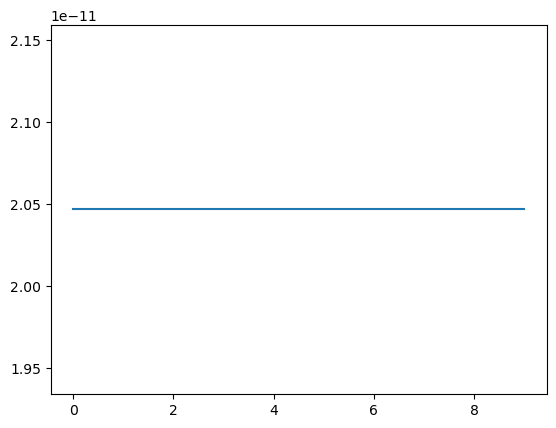

In [165]:
plt.plot(tildeY2_of_x)

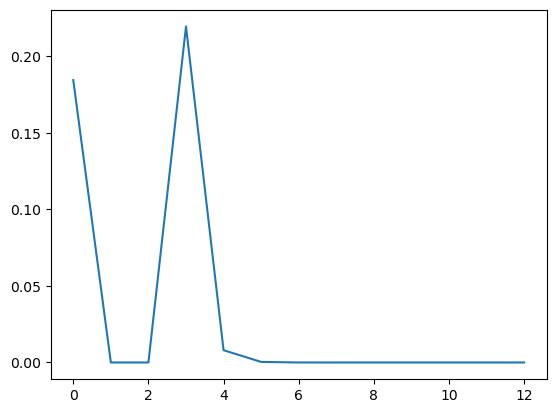

In [137]:
plt.plot(out.y[:,-1])

In [57]:
N2 = out.y[2]
N2[N2<0]

array([-6.22781434e-012, -6.45155292e-013, -4.99193520e-012, ...,
       -9.77967050e+153, -1.21148399e+154, -1.44422522e+154])

In [62]:
np.argwhere(N2<0)[0]

array([66])

In [64]:
N2[65]

3.295549396511145e-11

In [84]:
η2 = params['η2']

In [114]:
P, N1, N2 = y0[0:3]

In [117]:
N2

3.295549396511145e-11

In [128]:
y0

array([1.27516561e+01, 2.70105811e-07, 3.29554940e-11, 3.41280596e-01,
       1.78103212e+00, 1.36845590e+00, 6.80212361e-01, 2.61787823e-01,
       8.33696962e-02, 2.27140066e-02, 5.35158141e-03, 1.06131013e-03,
       1.57436546e-04])

In [125]:
out = solve_ivp(full_model, [0, 10], y0, method="LSODA",
                args=(1,params))

In [127]:
out

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  8.994e-02 ...  9.843e+00  1.000e+01]
        y: [[ 1.275e+01  1.264e+01 ...  4.766e+00  4.692e+00]
            [ 2.701e-07  2.395e-07 ... -2.008e-10 -1.895e-10]
            ...
            [ 1.061e-03  1.018e-03 ...  2.910e-05  2.782e-05]
            [ 1.574e-04  1.502e-04 ...  3.100e-06  2.948e-06]]
      sol: None
 t_events: None
 y_events: None
     nfev: 33
     njev: 0
      nlu: 0

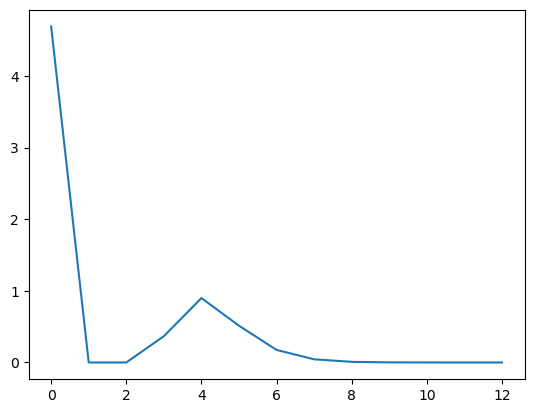

In [126]:
plt.plot(out.y[:,-1])

In [87]:
η2 = params['η2']; η1 = params['η1']
xvec = np.arange(1,11,1)
P = y0[0]
N1,N2 = y0[1], y0[2]
F_of_x_vec = y0[3:]


dN2dT = η2*N2*(1-N2) + np.sum(F_of_x_vec*fun_response_non_dim(xvec,N1,N2,2,**params))

In [80]:
F_of_x_vec

array([3.41280596e-01, 1.78103212e+00, 1.36845590e+00, 6.80212361e-01,
       2.61787823e-01, 8.33696962e-02, 2.27140066e-02, 5.35158141e-03,
       1.06131013e-03, 1.57436546e-04])

In [72]:
N2

3.295549396511145e-11

In [85]:

η2*N2*(1-N2) + np.sum(F_of_x_vec*fun_response_non_dim(xvec,N1,N2,2,**params))

1.6537566770538852e-10

In [100]:
y0 = out.y[:,65]

In [110]:
change_ = np.array(full_model(T, y0, 1, params.copy()))

In [111]:
change_

array([-1.27515681e+00, -3.86298533e-07, -4.80845652e-11,  1.18449941e-02,
       -5.55887495e-02, -1.10290975e-01, -9.42141997e-02, -5.23120585e-02,
       -2.19438842e-02, -7.47841753e-03, -2.14099425e-03, -5.04905303e-04,
       -8.49956356e-05])

In [112]:
y1 = y0 + change_*.001

In [113]:
y1

array([1.27503810e+01, 2.69719512e-07, 3.29074094e-11, 3.41292441e-01,
       1.78097653e+00, 1.36834561e+00, 6.80118146e-01, 2.61735511e-01,
       8.33477523e-02, 2.27065282e-02, 5.34944042e-03, 1.06080523e-03,
       1.57351551e-04])

In [107]:
y0[0]

12.75165612545899

In [93]:

change_2 = full_model(T, y1, 1, params.copy())

In [99]:
y1[0]

-3.5087049690043273

In [94]:
y2 = y1 + change_2*y1

In [97]:
change_2

[0.35087856807031953,
 -3.495241566175172e-07,
 -4.2986371309418706e-11,
 0.010457285603600663,
 -0.07539080972115678,
 -0.08672713331432011,
 -0.0808685795412253,
 -0.04970434318012962,
 -0.021640332491946603,
 -0.007434257541480261,
 -0.0021292132806106333,
 -0.0005017220661708774,
 -8.416120110607584e-05]

In [96]:
y2

array([-4.73983434e+00,  2.70105612e-07,  3.29554940e-11,  3.48934205e-01,
        1.55521741e+00,  1.11193489e+00,  5.66301407e-01,  2.35761855e-01,
        7.97756833e-02,  2.23765428e-02,  5.32875345e-03,  1.06024206e-03,
        1.57409916e-04])

In [56]:
out.y[2,1200:1350]

array([-3.37557493e+86, -4.02406508e+86, -4.98492299e+86, -5.94258903e+86,
       -7.36154812e+86, -8.77579357e+86, -1.08712594e+87, -1.29597642e+87,
       -1.60542698e+87, -1.91384958e+87, -2.37083462e+87, -2.82630159e+87,
       -3.50116003e+87, -4.17377665e+87, -5.17038238e+87, -6.16367749e+87,
       -7.63542762e+87, -9.10228875e+87, -1.12757144e+88, -1.34419201e+88,
       -1.66515539e+88, -1.98505256e+88, -2.45903930e+88, -2.93145150e+88,
       -3.63141741e+88, -4.32905810e+88, -5.36274162e+88, -6.39299134e+88,
       -7.91949655e+88, -9.44093087e+88, -1.16952168e+89, -1.39420142e+89,
       -1.72710594e+89, -2.05890459e+89, -2.55052555e+89, -3.04051340e+89,
       -3.76652089e+89, -4.49011665e+89, -5.56225739e+89, -6.63083659e+89,
       -8.21413401e+89, -9.79217186e+89, -1.21303264e+90, -1.44607137e+90,
       -1.79136130e+90, -2.13550420e+90, -2.64541547e+90, -3.15363286e+90,
       -3.90665077e+90, -4.65716724e+90, -5.76919597e+90, -6.87753066e+90,
       -8.51973317e+90, -

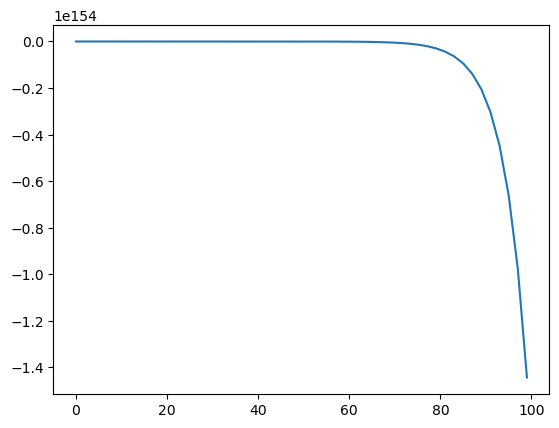

In [51]:
plt.plot(out.y[2,1900:])

In [38]:
out.y[:,1500]

-8.413043137260223e+111

# Base parameters

In [47]:
# base parameter and population size names
P_reg = 5
N1_reg = 1; N2_reg = 1
params_reg = dict(η1 = 0.2, η2 = 0.7, A1 = 0.5, β1 = 10, β2 = 2, H1=0, H2=0, 
                  α1_of_1=0.05, α2_of_1=0.95, 
                  s1=2, s2=2, α2_fun_type = 'constant',
                  x_max = 10, ξ = 2, d = 100,
                 Tx = 10, r = 0, γ = 0)



In [48]:
P = P_reg; N1 = N1_reg; N2 = N2_reg;
params = params_reg.copy()
x_max = params['x_max']
initialstate = np.array([P, *np.zeros(x_max - 1)])
t_f = 10


tsteps = 100
T=0
F_of_x_vec = initialstate
group_formation_model_non_dim(T, F_of_x_vec,P,N1,N2, params)

out = solve_ivp(group_formation_model_non_dim, [0, t_f], initialstate, method="LSODA",
                args=(P, N1, N2, params))


KeyError: 'pop_process'

In [10]:
out

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.405e-05 ...  9.265e+00  1.000e+01]
        y: [[ 5.000e+00  5.000e+00 ...  3.000e-01  2.724e-01]
            [ 0.000e+00  3.162e-05 ...  4.687e-01  4.553e-01]
            ...
            [ 0.000e+00  0.000e+00 ...  3.429e-125  2.432e-125]
            [ 0.000e+00  0.000e+00 ...  2.196e-166  1.500e-166]]
      sol: None
 t_events: None
 y_events: None
     nfev: 95
     njev: 0
      nlu: 0

In [7]:
initialstate

array([5., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
    x_max = params["x_max"]
    if not isinstance(initialstate,np.ndarray): # otherwise it's an array, and intiial state is given
        if np.isnan(initialstate):
            initialstate = np.array([P, *np.zeros(x_max - 1)])

    final_f_of_x = np.zeros((len(param_vec), x_max))
    at_equilibrium = np.zeros(len(param_vec))
    dfdt_final = np.zeros((len(param_vec), x_max))
    
    # run model for each parameter value
    for i, param in enumerate(param_vec):
        # put new parameter values into params dictionary
        if isinstance(param_key, list): # in case want to set multiple params to same value
            for pkey in param_key:
                params[pkey] = param
        else:
            params[param_key] = param

        # run the model using LSODA, like in odeint?
        #tsteps = 100
        #t_eval =  np.arange(0.0, t_f, delta_t)
        #out = solve_ivp(group_formation_model_separate, [0, t_f], initialstate, method="RK45",
        #        args=(P, N1, N2, pop_process, params))
        out = solve_ivp(group_formation_model_non_dim, [0, t_f], initialstate, method="LSODA",
                args=(P, N1, N2, params))
        final_distribution = np.transpose(out.y)[-1]
        
        # check at equilibrium
        dfdt_final[i,:], at_equilibrium[i] = check_at_equilibrium(final_distribution, P, N1, N2,pop_process,**params)
        
        
        final_f_of_x[i,:] = final_distribution
        

    return final_f_of_x, at_equilibrium, dfdt_final

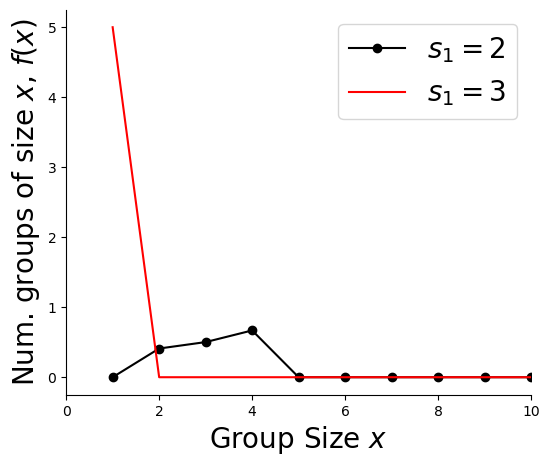

In [60]:
params = params_reg.copy()



out = plot_f_of_x(P=P_reg, N1=N1_reg, N2=N2_reg,
                  param_vec = [2,3], param_key="s1", 
            linelabel = r'$s_1=$'+'%d', params = params_reg.copy(), pop_process = False, 
                delta_t = 0.01, t_f = 50000, initialstate = np.nan)

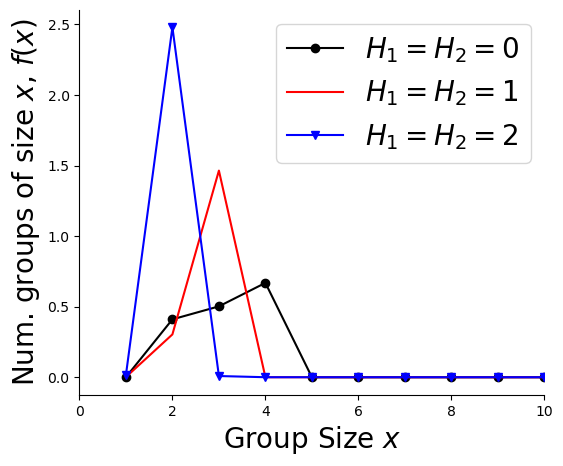

In [63]:
params = params_reg.copy()



out = plot_f_of_x(P=P_reg, N1=N1_reg, N2=N2_reg,
                  param_vec = [0,1,2], param_key=["H1","H2"], 
            linelabel = r'$H_1=H_2=$'+'%d', params = params_reg.copy(), pop_process = False, 
                delta_t = 0.01, t_f = 50000, initialstate = np.nan)

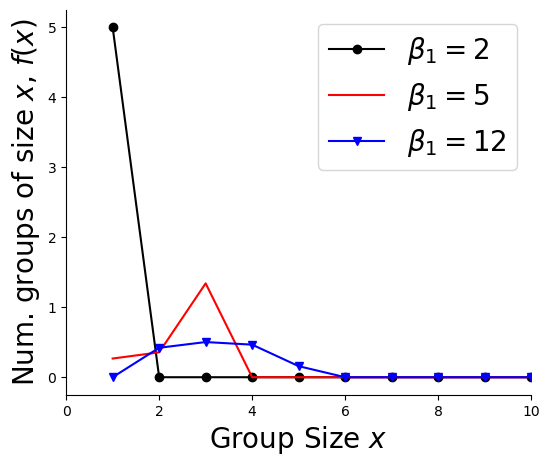

In [64]:
params = params_reg.copy()



out = plot_f_of_x(P=P_reg, N1=N1_reg, N2=N2_reg,
                  param_vec = [2,5,12], param_key=["β1"], 
            linelabel = r'$\beta_1=$'+'%d', params = params_reg.copy(), pop_process = False, 
                delta_t = 0.01, t_f = 50000, initialstate = np.nan)

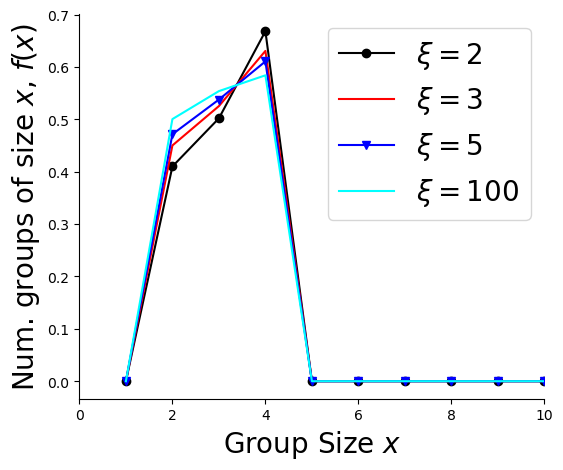

In [65]:
params = params_reg.copy()



out = plot_f_of_x(P=P_reg, N1=N1_reg, N2=N2_reg,
                  param_vec = [2,3,5,100], param_key="ξ", 
            linelabel = r'$\xi=$'+'%d', params = params_reg.copy(), pop_process = False, 
                delta_t = 0.01, t_f = 50000, initialstate = np.nan)